# Machine Learning, Fall 1401
Homework1- Question5

Fatemeh Taherinezhad-810101219

In [36]:
import numpy
import pandas as pd
from random import seed
from random import randrange
from math import pi, sqrt, exp
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

## Implementing naive bayes without libraries

`cross_validation_split()`

This function takes the dataset and the number of folds it should devid it into, and splits thet dataset in to folds. 

`seperate_by_class()`

NB classifier calculated the probability of belonging to each class separately and therefore, the dataset should split up base on calss labels.

`mean()` and `stdv()`

These functions calculate the mean and standard deviation of each feature.

`summarise_dataset()` 

Stores the mean, std and length of each column into a dictionary for later use in the algorithm.

`summarize_by_class()`

For each class, it calculates the summary for each feature(column).

`calculate_probability()`

This function is the implementation of Gaussian distribition and will be used in predicting sample classes. 

In [32]:
# Read the csv file and return dataframe
def read_data(filename):
    df = pd.read_csv('Data/' + filename)
    return df.values.tolist()

# Split data to train and test using a k-fold manner
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for _ in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Split the dataset by class values, returns a dictionary
def separate_by_class(dataset):
    separated = dict()
    for i in range(len(dataset)):
        vector = dataset[i]
        class_value = vector[-1]
        if (class_value not in separated):
            separated[class_value] = list()
        separated[class_value].append(vector)
    return separated

# Calculate the mean of a list of numbers
def mean(numbers):
    return sum(numbers)/float(len(numbers))
 
# Calculate the standard deviation of a list of numbers
def stdev(numbers):
    avg = mean(numbers)
    variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
    return sqrt(variance)

# Calculate the mean, stdev and count for each column in a dataset
def summarize_dataset(dataset):
    summaries = [(mean(column), stdev(column), len(column)) for column in zip(*dataset)]
    del(summaries[-1]) # exclude label summary
    return summaries
 
# Split dataset by class then calculate statistics for each row
def summarize_by_class(dataset):
    separated = separate_by_class(dataset)
    summaries = dict()
    for class_value, rows in separated.items():
        summaries[class_value] = summarize_dataset(rows)
    return summaries
 
# Calculate the Gaussian probability distribution function for x
def calculate_probability(x, mean, stdev):
    exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
    return (1 / (sqrt(2 * pi) * stdev)) * exponent

`evaluate_algorithm()`

This funciton does the main job of this problem. It first builds the data folds and splits it to train and test data. It then removes class column from the test set and use the `classifier` to predict classes for the test data. Then the precision, recall and confusion matrix for each fold is calculated and reported at the end. 

In [54]:
# Evaluating the classification using the k-fold manner
def evaluate_algorithm(dataset, classifier, n_folds, *args):
    recalls = list()
    precisions = list()
    conf_matrices = list()
    folds = cross_validation_split(dataset, n_folds)
    for fold in folds:
        train_data = list(folds)
        train_data.remove(fold)
        train_data = sum(train_data, [])
        test_data = list()
        for row in fold:
            row_copy = list(row)
            test_data.append(row_copy)
            row_copy[-1] = None
        predicted = classifier(train_data, test_data, *args)
        actual = [row[-1] for row in fold]
        
        recall = recall_score(actual, predicted, average='binary')
        recalls.append(recall)
        
        precision = precision_score(actual, predicted, average='binary')
        precisions.append(precision)
        
        conf_matrices.append(confusion_matrix(actual, predicted))
        
    avg_recall = sum(r for r in recalls)/len(recalls)
    avg_precision = sum(p for p in precisions)/len(precisions)
    
    print("Average recall: ", avg_recall)
    print("Average precision: ", avg_precision)
    
    for i in range(len(conf_matrices)):
        cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrices[i], display_labels = [False, True])
        fig, ax = plt.subplots(figsize=(3,3))
        cm_display.plot(ax=ax)
    return

`calculate_class_probability()`

This function is based on the naive bayes rule and for each record, calculates the probability of the row belonging to a class. This is done by multiplying the probability of that class given each feature. The probaility is then returned to `predict()` to be compared with the probability of belonging to other classes. Class lable with maximum probability is assigned to the record. 

In [26]:
# Calculate the probabilities of predicting each class for a given row
def calculate_class_probabilities(summaries, row):
    total_rows = sum([summaries[label][0][2] for label in summaries])
    probabilities = dict()
    for class_value, class_summaries in summaries.items():
        probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
        for i in range(len(class_summaries)):
            mean, stdev, _ = class_summaries[i]
            probabilities[class_value] *= calculate_probability(row[i], mean, stdev)
    return probabilities
 
# Predict the class for a given row
def predict(summaries, row):
    probabilities = calculate_class_probabilities(summaries, row)
    best_label, best_prob = None, -1
    for class_value, probability in probabilities.items():
        if best_label is None or probability > best_prob:
            best_prob = probability
            best_label = class_value
    return best_label
 
# Naive Bayes Algorithm
def naive_bayes(train, test):
    summarize = summarize_by_class(train)
    predictions = list()
    for row in test:
        output = predict(summarize, row)
        predictions.append(output)
    return(predictions)

Average recall:  0.9666626648037402
Average precision:  0.8884843629248577


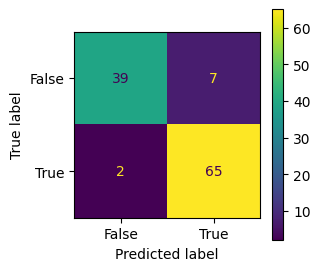

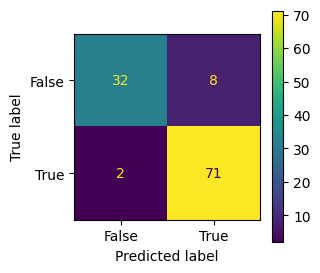

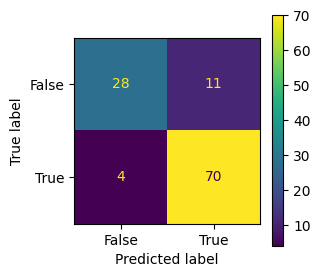

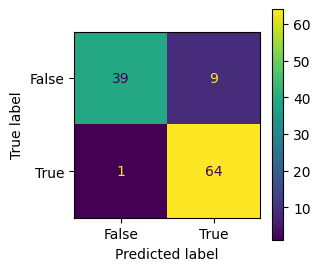

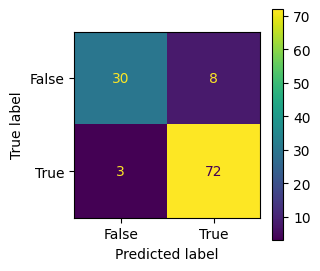

In [55]:
seed(1)
filename = 'Breast_cancer_data.csv'
dataset = read_data(filename)
# print(type(dataset))
# print((dataset[0][5]))
# evaluate algorithm
n_folds = 5
evaluate_algorithm(dataset, naive_bayes, n_folds)

## Implementing naive bayes using sklearn

In [87]:
import numpy
import pandas as pd
from random import seed
from random import randrange
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

The approach is the same to the last part. All that is different is the way kfold is perfomed with `sklearn` and also using the `GaussianNB` for the classifying part. 

In [80]:
def read_data2(filename):
    df = pd.read_csv('Data/' + filename)
    X = df.iloc[:, :5]
    Y = df.iloc[:, 5]
    return (X, Y)
    

# Evaluating the classification using the k-fold manner
def evaluate_sklearn_NB(X, Y, classifier, n_folds, *args):
    recalls = list()
    precisions = list()
    conf_matrices = list()
    kf = KFold(n_splits=n_folds, random_state=1, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        predicted = classifier.fit(X_train, Y_train).predict(X_test)
        
        recall = recall_score(Y_test, predicted, average='binary')
        recalls.append(recall)
        
        precision = precision_score(Y_test, predicted, average='binary')
        precisions.append(precision)
        
        conf_matrices.append(confusion_matrix(Y_test, predicted))
        
    avg_recall = sum(r for r in recalls)/len(recalls)
    avg_precision = sum(p for p in precisions)/len(precisions)
    
    print("Average recall: ", avg_recall)
    print("Average precision: ", avg_precision)
    
    for i in range(len(conf_matrices)):
        cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrices[i], display_labels = [False, True])
        fig, ax = plt.subplots(figsize=(3,3))
        cm_display.plot(ax=ax)
    return

Average recall:  0.9639947696876675
Average precision:  0.8923030498199562


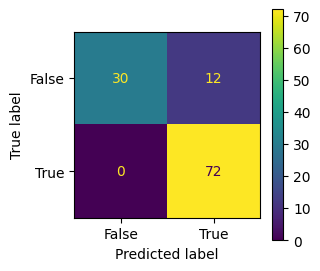

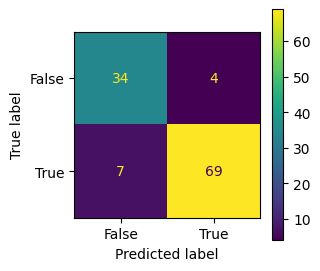

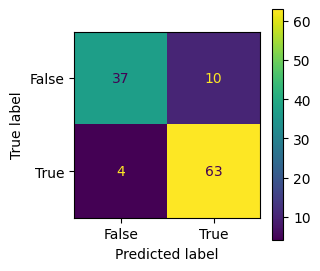

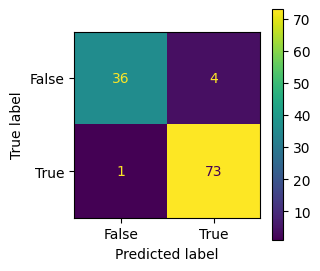

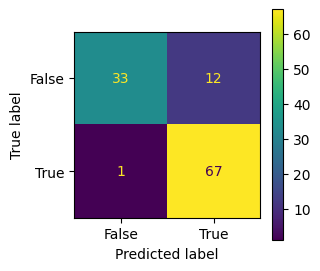

In [86]:
seed(1)
filename = 'Breast_cancer_data.csv'
X, Y = read_data2(filename)
# evaluate algorithm
n_folds = 5
gnb = GaussianNB()
evaluate_sklearn_NB(X.to_numpy(), Y.to_numpy(), gnb, n_folds)
